In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'Monospace'
plt.rcParams['figure.figsize'] = [8,6]

In [3]:
#First we define as few variables
N = 200 #resolution
delta = 2*np.pi/N #Spacing between points

# E1
#### a) Defining a sparse matrix that is elementwise cosine

In [4]:
#Defining the phi values, this is essentially our potential
phi = np.linspace(-np.pi, np.pi, N)

cosMatrix = np.diag(np.cos(phi))

#### b) The $q^2$ matrix

In [5]:
diagArr = np.ones(N)
offDiagArr = np.ones(N-1)

q2Matrix = 1/delta**2 * (2*np.diag(diagArr) - np.diag(offDiagArr, k = 1) - np.diag(offDiagArr, k = -1))
q2Matrix[1][N-1], q2Matrix[N-1][1] = 1/delta**2, 1/delta**2  #Periodic boundary conditions

#### c) The tunable transmon Hamiltonian
The Hamiltonian is given by equation (22) from "A Qunatum Engineer's Guide to Superconducting Qubits" and is 
$$H=4E_Cn^2-E_J\sqrt{\cos(\varphi_e)^2+d^2\sin(\varphi_e)}\cos(\varphi)$$

In [6]:
#Defining a function that returns the Hamiltonian, which is the sum of the potential and kinetic energy and the energy scale which will be used for plotting later
def hamiltonian(E_C, E_J, phi_e, d=1):
    E_kin = 4*E_C*q2Matrix
    E_pot = -E_J*np.sqrt(np.cos(phi_e)**2+d**2*np.sin(phi_e)**2)*cosMatrix
    return E_kin + E_pot, E_J*np.sqrt(np.cos(phi_e)**2+d**2*np.sin(phi_e)**2)

#### d) Computing the eigenvalues and eigen vectors

In [7]:
H, scale = hamiltonian(1, 50, phi_e=0)

#k is number of eigenvalues and eigenvectors it finds and SR it means that it finds the pairs that have the eigenvalues with the smallest real part
eigenvalues, eigenvectors = sc.sparse.linalg.eigs(H, k=7, which = "SR")  


c:\Users\marku\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Cosine potential')

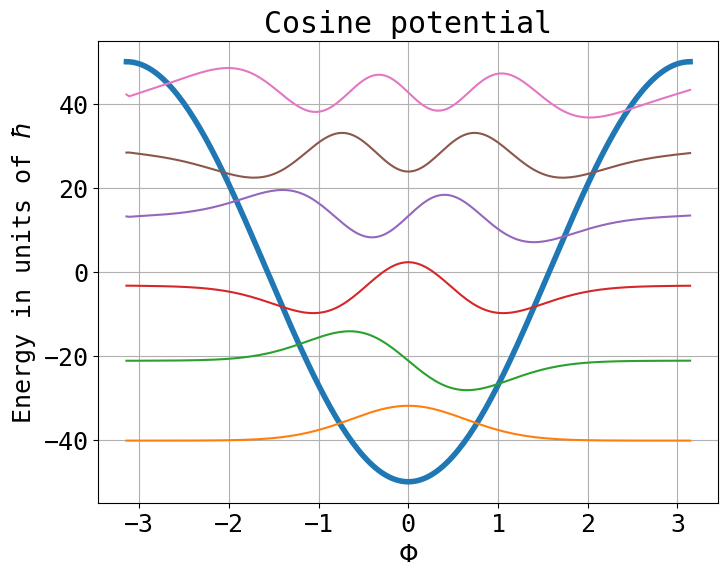

In [8]:
#We can then plot our potential and our wavefunctions

plt.plot(phi, -scale*np.cos(phi), linewidth = 4)

for i in range(1, 7):
    plt.plot(phi, -eigenvectors[:,i]*scale + eigenvalues.real[i])

plt.xlabel("$\Phi$")
plt.ylabel("Energy in units of $\hbar$")
plt.title("Cosine potential")

# E2)

To find the relaxation time well use equation (54) from from "A Qunatum Engineer's Guide to Superconducting Qubits"
$$\Gamma_1=\frac{1}{\hbar^2}｜<0｜\frac{\partial H}{\partial \lambda}｜1>｜^2S(\omega_q)$$

Let us start by finding the flux noise
$$\frac{\partial H}{\partial \varphi_e}=\frac{(d^2-1)\sin(\varphi_e)\cos(\varphi_e)}{\sqrt{\cos(\varphi_e)^2+d^2\sin(\varphi_e)^2}}$$


In [9]:
phi_e = np.linspace(0, 2*np.pi, 80)

def flux_noise(phi_e, d):
    return (d**2-1)*np.sin(phi_e)*np.cos(phi_e)/np.sqrt(np.cos(phi_e)**2+d**2*np.sin(phi_e)**2)

flux_relaxation_arr = np.zeros_like(phi_e)
driving_frequency_flux = np.zeros_like(phi_e)

A_flux=1e-6

def spectral(A, omega):
    return 2*np.pi*A**2/np.abs(omega)

for i in range(len(phi_e)):
    Ham = hamiltonian(1, 50, phi_e[i], d=2)
    energy, state = sc.sparse.linalg.eigs(H, k=2, which = "SR")  
    driving_frequency_flux[i] = energy[1]-energy[0]

    flux_relaxation_arr[i] = np.matmul(eigenvectors[:,0], np.matmul(50*flux_noise(phi_e[i], d=2)*cosMatrix, eigenvectors[:,1]))**2 * spectral(A_flux, energy[1]-energy[0])



C:\Users\marku\AppData\Local\Temp\ipykernel_18744\3933325300.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  driving_frequency_flux[i] = energy[1]-energy[0]
C:\Users\marku\AppData\Local\Temp\ipykernel_18744\3933325300.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  flux_relaxation_arr[i] = np.matmul(eigenvectors[:,0], np.matmul(50*flux_noise(phi_e[i], d=2)*cosMatrix, eigenvectors[:,1]))**2 * spectral(A_flux, energy[1]-energy[0])


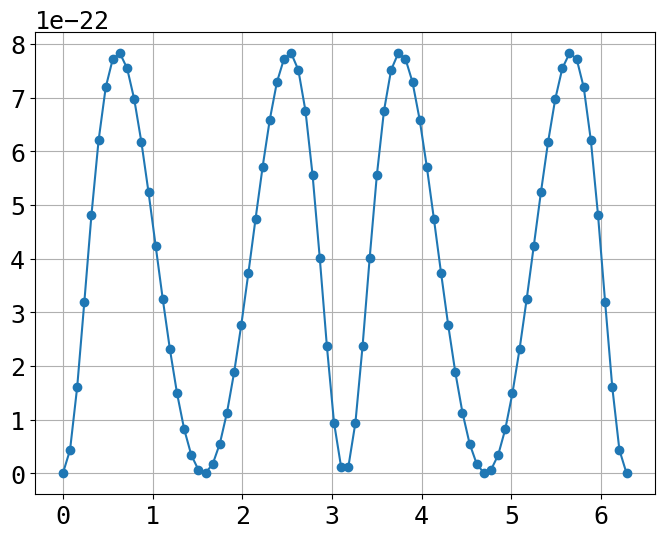

In [10]:
plt.plot(phi_e, flux_relaxation_arr, '-o')

For the charge noise we need to define the $q$ matrix

C:\Users\marku\AppData\Local\Temp\ipykernel_18744\1808710448.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  driving_frequency_charge[i] = energy[1]-energy[0]


Text(0.5, 0, '$\\varphi_e$')

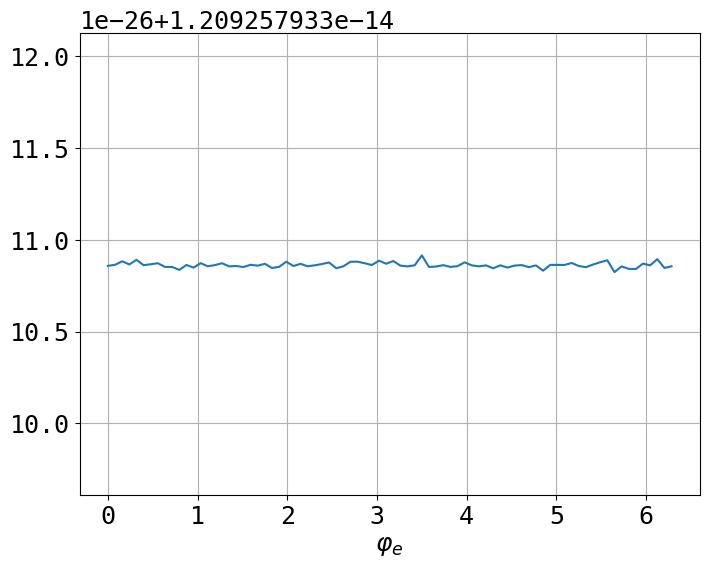

In [15]:
qMatrix = -1j/(2*delta) * (np.diag(offDiagArr, k = 1) - np.diag(offDiagArr, k = -1))

A_charge = 1e-4

charge_relaxation_arr =np.zeros_like(phi_e)
driving_frequency_charge = np.zeros_like(phi_e)



for i in range(len(phi_e)):
    Ham = hamiltonian(1, 50, phi_e[i], d=2)
    energy, state = sc.sparse.linalg.eigs(H, k=2, which = "SR")  
    driving_frequency_charge[i] = energy[1]-energy[0]

    charge_relaxation_arr[i] =np.absolute( np.matmul(eigenvectors[:,0], np.matmul(8*qMatrix, eigenvectors[:,1])))**2 * spectral(A_charge, energy[1]-energy[0])


plt.plot(phi_e, charge_relaxation_arr)
plt.xlabel("$\\varphi_e$")

Ohmic noise

In [14]:
ohmic_relaxation_arr = np.zeros(50)

B_ohmic = 5.2e-9

#Loops over E_J/E_C
for i in range(50):
    Ham = hamiltonian(1, i, 0, d=2)
    energy, state = sc.sparse.linalg.eigs(H, k=2, which = "SR")  
    driving_frequency_charge[i] = energy[1]-energy[0]

    ohmic_relaxation_arr[i] =np.absolute( np.matmul(eigenvectors[:,0], np.matmul(8*qMatrix, eigenvectors[:,1])))**2 * B_ohmic**2 * (energy[1]-energy[0])/(2*np.pi)

C:\Users\marku\AppData\Local\Temp\ipykernel_18744\3925945618.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  driving_frequency_charge[i] = energy[1]-energy[0]
C:\Users\marku\AppData\Local\Temp\ipykernel_18744\3925945618.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  ohmic_relaxation_arr[i] =np.absolute( np.matmul(eigenvectors[:,0], np.matmul(8*qMatrix, eigenvectors[:,1])))**2 * B_ohmic**2 * (energy[1]-energy[0])/(2*np.pi)


Text(0.5, 0, '$\\varphi_e$')

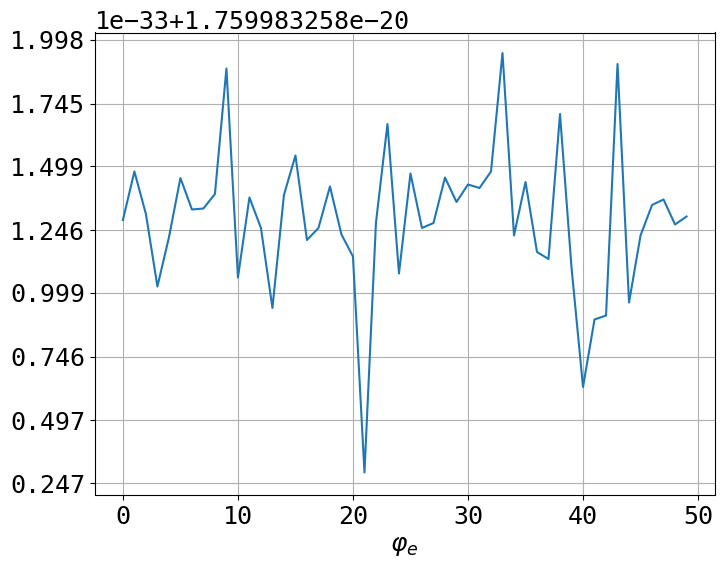

In [16]:
plt.plot(range(50), ohmic_relaxation_arr)
plt.xlabel("$\\varphi_e$")